# Module composition

Given our co-acting gene modules, we will now calculate the composition of those modules - are modules predominantly core, predominantly accessory or mixed.

The strategy we will use will be the following:

1. Given _N_ accessory genes, sample _N_ core genes 100 times
2. For each module in the network, compare the number of accessory genes in the module to the distribution of core gene counts in that module from your 100 samples
    * if the number of accessory genes < 10th quantile of core genes then the module is mostly core
    * if the number of accessory genes > 90th quantile of core genes then the module is mostly accessory
    * else the module is mixed

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from core_acc_modules import utils, paths

random.seed(1)

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# User params
method = "affinity"
num_samples = 100

### Import module memberships

In [3]:
# Import module memberships
pao1_membership_filename = os.path.join(
    paths.LOCAL_DATA_DIR, f"pao1_modules_{method}.tsv"
)
pa14_membership_filename = os.path.join(
    paths.LOCAL_DATA_DIR, f"pa14_modules_{method}.tsv"
)

pao1_membership = pd.read_csv(pao1_membership_filename, sep="\t", index_col=0, header=0)
pa14_membership = pd.read_csv(pa14_membership_filename, sep="\t", index_col=0, header=0)

In [4]:
pao1_membership.head()

,module id
PA0001,390
PA0002,0
PA0003,491
PA0004,298
PA0005,522


In [5]:
pa14_membership.head()

,module id
PA14_55610,425
PA14_55600,168
PA14_55590,425
PA14_55580,379
PA14_55570,189


### Map core/accessory labels to genes

In [6]:
# Read in expression data
pao1_expression_filename = paths.PAO1_COMPENDIUM
pa14_expression_filename = paths.PA14_COMPENDIUM

pao1_expression = pd.read_csv(pao1_expression_filename, sep="\t", index_col=0, header=0)
pa14_expression = pd.read_csv(pa14_expression_filename, sep="\t", index_col=0, header=0)

In [7]:
pao1_annot_filename = paths.GENE_PAO1_ANNOT
pa14_annot_filename = paths.GENE_PA14_ANNOT

core_acc_dict = utils.get_my_core_acc_genes(
    pao1_annot_filename, pa14_annot_filename, pao1_expression, pa14_expression
)

Number of PAO1 core genes: 5366
Number of PA14 core genes: 5363
Number of PAO1 core genes in my dataset: 5361
Number of PA14 core genes in my dataset: 5361
Number of PAO1-specific genes: 202
Number of PA14-specific genes: 530


In [8]:
pao1_core = core_acc_dict["core_pao1"]
pa14_core = core_acc_dict["core_pa14"]
pao1_acc = core_acc_dict["acc_pao1"]
pa14_acc = core_acc_dict["acc_pa14"]

### Get matched number of core genes

In [9]:
# Sample same number of accessory genes from core genes `num_samples` times
# Store sets of core genes in a df
ls_core_pao1_samples = []
ls_core_pa14_samples = []

num_pao1_acc = len(pao1_acc)
num_pa14_acc = len(pa14_acc)

for i in range(num_samples):
    pao1_sample = random.sample(pao1_core, num_pao1_acc)
    pa14_sample = random.sample(pa14_core, num_pa14_acc)

    ls_core_pao1_samples.append(pao1_sample)
    ls_core_pa14_samples.append(pa14_sample)

In [10]:
assert len(ls_core_pao1_samples) == num_samples
assert len(ls_core_pa14_samples) == num_samples

In [11]:
assert len(ls_core_pao1_samples[0]) == num_pao1_acc
assert len(ls_core_pa14_samples[0]) == num_pa14_acc

### Calculate composition of modules

In [12]:
# Get list of modules ids
pao1_module_ids = pao1_membership["module id"].unique()
pa14_module_ids = pa14_membership["module id"].unique()

In [13]:
print(len(pao1_module_ids))
print(len(pa14_module_ids))

564
593


In [14]:
# For each module get the distribution of number of core genes
pao1_gene_group_composition = pd.DataFrame(
    index=pao1_module_ids, columns=range(0, num_samples)
)
pa14_gene_group_composition = pd.DataFrame(
    index=pa14_module_ids, columns=range(0, num_samples)
)


def get_module_composition(membership_df, core_samples_list, acc_genes, composition_df):
    # Get number of core genes from each sampling per module
    for i in range(len(core_samples_list)):
        num_core_genes = membership_df.loc[core_samples_list[i]][
            "module id"
        ].value_counts()
        composition_df[i] = num_core_genes

    # Get the number of accessory genes per module
    num_acc_genes = membership_df.loc[acc_genes]["module id"].value_counts()
    composition_df["acc"] = num_acc_genes

    composition_df = composition_df.fillna(0)

    return composition_df

In [15]:
pao1_gene_group_composition_processed = get_module_composition(
    pao1_membership, ls_core_pao1_samples, pao1_acc, pao1_gene_group_composition
)
pa14_gene_group_composition_processed = get_module_composition(
    pa14_membership, ls_core_pa14_samples, pa14_acc, pa14_gene_group_composition
)

In [16]:
pao1_gene_group_composition_processed.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,acc
390,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
491,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
298,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
522,2.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,2.0,0.0,1.0,0.0,0.0


In [17]:
pa14_gene_group_composition_processed.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,acc
425,2.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,2.0,...,1.0,2.0,3.0,2.0,2.0,2.0,1.0,2.0,1.0,0.0
168,1.0,0.0,1.0,2.0,0.0,2.0,2.0,2.0,1.0,1.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
379,5.0,2.0,1.0,0.0,0.0,1.0,0.0,2.0,1.0,1.0,...,2.0,2.0,0.0,1.0,2.0,2.0,2.0,3.0,1.0,2.0
189,1.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
255,2.0,0.0,5.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,...,0.0,2.0,0.0,2.0,0.0,1.0,3.0,1.0,3.0,4.0


In [18]:
# For a given module,
# If the number of accessory genes < 10th quantile of core genes then the module is core
# If the number of accessory genes > 90th quantile of core genes then the module is accessory
# Else the module is mixed
def label_modules(module_composition_df):
    core_composition = module_composition_df.drop("acc", axis=1)

    module_composition_df["module label"] = "mixed"
    module_composition_df.loc[
        module_composition_df["acc"] < core_composition.quantile(0.1, axis=1),
        "module label",
    ] = "mostly core"
    module_composition_df.loc[
        module_composition_df["acc"] > core_composition.quantile(0.9, axis=1),
        "module label",
    ] = "mostly accessory"

    return module_composition_df

In [19]:
pao1_module_labels = label_modules(pao1_gene_group_composition_processed)
pa14_module_labels = label_modules(pa14_gene_group_composition_processed)

In [20]:
pao1_module_labels.head()

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,acc,module label
390,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,mixed
0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,mixed
491,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,mixed
298,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,mixed
522,2.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,2.0,0.0,1.0,0.0,0.0,mixed


In [21]:
pa14_module_labels.head()

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,acc,module label
425,2.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,2.0,...,2.0,3.0,2.0,2.0,2.0,1.0,2.0,1.0,0.0,mixed
168,1.0,0.0,1.0,2.0,0.0,2.0,2.0,2.0,1.0,1.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,mixed
379,5.0,2.0,1.0,0.0,0.0,1.0,0.0,2.0,1.0,1.0,...,2.0,0.0,1.0,2.0,2.0,2.0,3.0,1.0,2.0,mixed
189,1.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,mixed
255,2.0,0.0,5.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,...,2.0,0.0,2.0,0.0,1.0,3.0,1.0,3.0,4.0,mixed


### Examine module composition

In [22]:
pao1_module_labels["module label"].value_counts()

mixed               538
mostly accessory     26
Name: module label, dtype: int64

In [23]:
pa14_module_labels["module label"].value_counts()

mixed               528
mostly accessory     52
mostly core          13
Name: module label, dtype: int64

In [25]:
# Add size of modules to df
pao1_module_labels["size"] = pao1_membership["module id"].value_counts()
pa14_module_labels["size"] = pa14_membership["module id"].value_counts()

In [26]:
pao1_module_labels.head()

,0,1,2,3,4,5,6,7,8,9,...,93,94,95,96,97,98,99,acc,module label,size
390,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,mixed,12
0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,mixed,14
491,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,mixed,11
298,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,mixed,10
522,2.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,1.0,1.0,1.0,2.0,0.0,1.0,0.0,0.0,mixed,19


In [27]:
pa14_module_labels.head()

,0,1,2,3,4,5,6,7,8,9,...,93,94,95,96,97,98,99,acc,module label,size
425,2.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,2.0,...,3.0,2.0,2.0,2.0,1.0,2.0,1.0,0.0,mixed,11
168,1.0,0.0,1.0,2.0,0.0,2.0,2.0,2.0,1.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,mixed,9
379,5.0,2.0,1.0,0.0,0.0,1.0,0.0,2.0,1.0,1.0,...,0.0,1.0,2.0,2.0,2.0,3.0,1.0,2.0,mixed,18
189,1.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,mixed,9
255,2.0,0.0,5.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,...,0.0,2.0,0.0,1.0,3.0,1.0,3.0,4.0,mixed,26


Text(0.5, 1.0, 'Size distribution of PAO1 mostly accessory modules')

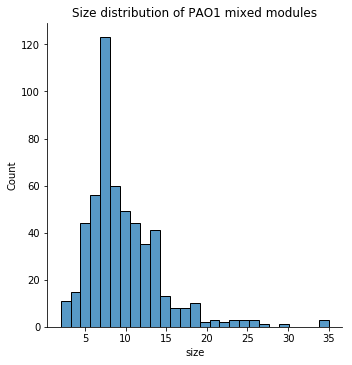

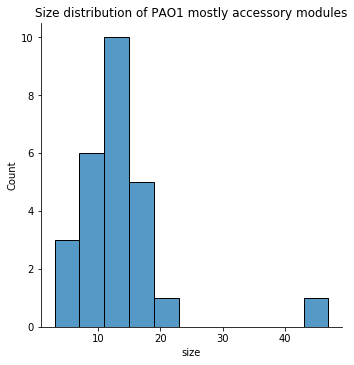

In [42]:
# Size distributions of PAO1 modules
f1 = sns.displot(
    pao1_module_labels.loc[pao1_module_labels["module label"] == "mixed", "size"]
)
plt.title("Size distribution of PAO1 mixed modules")

f2 = sns.displot(
    pao1_module_labels.loc[
        pao1_module_labels["module label"] == "mostly accessory", "size"
    ]
)
plt.title("Size distribution of PAO1 mostly accessory modules")

Text(0.5, 1.0, 'Size distribution of PA14 mostly core modules')

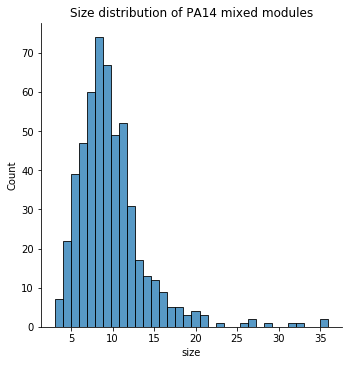

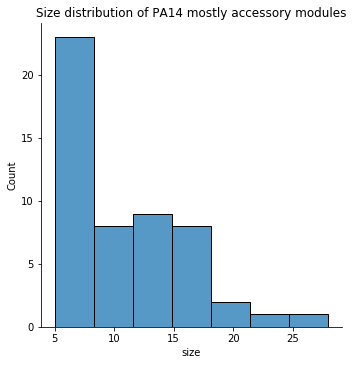

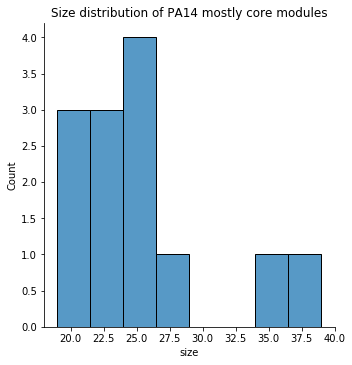

In [43]:
# Size distributions of PA14 moduels
g1 = sns.displot(
    pa14_module_labels.loc[pa14_module_labels["module label"] == "mixed", "size"]
)
plt.title("Size distribution of PA14 mixed modules")

g2 = sns.displot(
    pa14_module_labels.loc[
        pa14_module_labels["module label"] == "mostly accessory", "size"
    ]
)
plt.title("Size distribution of PA14 mostly accessory modules")

g3 = sns.displot(
    pa14_module_labels.loc[pa14_module_labels["module label"] == "mostly core", "size"]
)
plt.title("Size distribution of PA14 mostly core modules")

In [29]:
# TO DO: Compare the composition across partitions
# Save the matrix that maps module id to module label per partition
# In another notebook look through module labels per partition
# Calculate consistency of labeling using ARI for each pair of partitions

**Takeaway:**
* Most modules are mixed, some are mostly accessory. Only PA14 compendium have some mostly core modules
* PAO1 mixed and mostly accessory modules have similar sizes (~10 genes)
* PA14 mixed modules are ~10 genes, mostly accessory modules are smaller ~5 genes, mostly core modules are larger ~ 20 genes